In [1]:
import keras 
from keras.models import Sequential, Model
from keras.utils import np_utils 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import AveragePooling2D,Activation, ZeroPadding2D,Flatten,Input,Add,Dense,Conv2D,BatchNormalization 
from keras.datasets import cifar10
import matplotlib.pyplot as plt 
import numpy as np
from keras import regularizers 
import time 

Using TensorFlow backend.


In [2]:
#Load the images 
image_size = 32 
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = cifar10.load_data()

#Normalize the image 


170500096/170498071 [==============================] - 24s 0us/step


In [3]:
mean =np.mean(x_train_raw,axis=3)
len(mean)

50000

In [0]:
x_train_raw = x_train_raw.astype('float32')
x_test_raw = x_test_raw.astype('float32')

y_train_raw = np_utils.to_categorical(y_train_raw)
y_test_raw = np_utils.to_categorical(y_test_raw)
weight_decay = 0.0001

In [0]:
def identity_block(input_tensor,kernel_size,filters):
    filter1, filter2 = filters
    x = Conv2D(filter1,kernel_size,padding='same',kernel_initializer='he_normal'
               ,kernel_regularizer=regularizers.l2(weight_decay))(input_tensor)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    x = Conv2D(filter2,kernel_size,padding='same',kernel_initializer='he_normal'
               ,kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = BatchNormalization(axis=3)(x)
    
    x = Add()([x,input_tensor])
    x = Activation('relu')(x)
    return x 

In [0]:
def conv_block(input_tensor,kernel_size,filters,strides=(2,2)):
    filter1, filter2 = filters 
    x = Conv2D(filter1,kernel_size,strides=strides,padding='same',kernel_initializer='he_normal'
               ,kernel_regularizer=regularizers.l2(weight_decay))(input_tensor)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filter2, kernel_size,padding='same',kernel_initializer='he_normal'
               ,kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = BatchNormalization(axis=3)(x)
    
    x_final = Conv2D(filter2,(1,1),strides=strides,padding='same',kernel_initializer='he_normal'
               ,kernel_regularizer=regularizers.l2(weight_decay))(input_tensor)
    x_final = BatchNormalization(axis=3)(x_final)
    
    x = Add()([x,x_final])
    x = Activation('relu')(x)
    
    return x 
    
    
    
    
    
    
    
    
    

In [7]:
#Build the model(ResNet 56 )
input_x = Input(shape=(32,32,3))
#Stage 1
x = Conv2D(16,(3,3),padding='same',kernel_initializer='he_normal'
               ,kernel_regularizer=regularizers.l2(weight_decay))(input_x)
x = BatchNormalization(axis=3)(x)
x = Activation('relu')(x)

#Stage 2 
x = identity_block(x,(3,3),[16,16])
x = identity_block(x,(3,3),[16,16])
x = identity_block(x,(3,3),[16,16])
x = identity_block(x,(3,3),[16,16])
x = identity_block(x,(3,3),[16,16])
x = identity_block(x,(3,3),[16,16])
x = identity_block(x,(3,3),[16,16])
x = identity_block(x,(3,3),[16,16])
x = identity_block(x,(3,3),[16,16])

#Stage 3 
x = conv_block(x,(3,3),[32,32])
x = identity_block(x,(3,3),[32,32])
x = identity_block(x,(3,3),[32,32])
x = identity_block(x,(3,3),[32,32])
x = identity_block(x,(3,3),[32,32])
x = identity_block(x,(3,3),[32,32])
x = identity_block(x,(3,3),[32,32])
x = identity_block(x,(3,3),[32,32])
x = identity_block(x,(3,3),[32,32])


#Stage 4 
x = conv_block(x,(3,3),[64,64])
x = identity_block(x,(3,3),[64,64])
x = identity_block(x,(3,3),[64,64])
x = identity_block(x,(3,3),[64,64])
x = identity_block(x,(3,3),[64,64])
x = identity_block(x,(3,3),[64,64])
x = identity_block(x,(3,3),[64,64])
x = identity_block(x,(3,3),[64,64])
x = identity_block(x,(3,3),[64,64])


#Satge 5 
x = AveragePooling2D((8,8))(x)
x = Flatten()(x)
x = Dense(10,activation='softmax')(x)

model = Model(input_x,outputs=x)
model.summary()





Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_____________________________________

In [0]:
#Model fit 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
datagen = ImageDataGenerator(horizontal_flip=True,
                            width_shift_range=0.125,
                            height_shift_range=0.125,
                            fill_mode='constant',
                            cval=0.)
datagen = ImageDataGenerator(horizontal_flip=True,
                            width_shift_range=0.125,
                            height_shift_range=0.125,
                            fill_mode='constant',
                            cval=0.)
datagen.fit(x_train_raw)
model.fit_generator(datagen.flow(x_train_raw, y_train_raw,batch_size=128),
         epochs = 100,
         steps_per_epoch = 500,
         validation_data=(x_test_raw,y_test_raw),
         verbose=1)


In [0]:
# Functions for plots
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2,figsize=(10, 5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'validation'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'validation'], loc='best')
    plt.show()

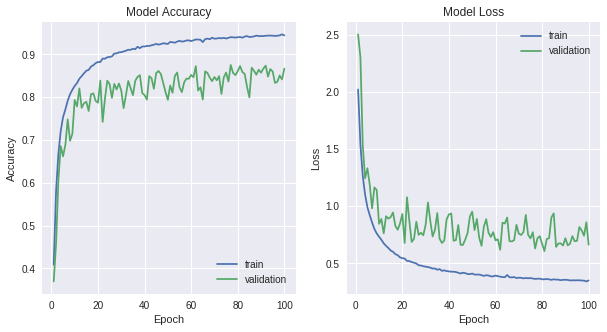

In [10]:
plot_model_history(model.history)